In [159]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx

In [3]:
real_estate: pd.DataFrame = pd.read_excel('data/Real estate valuation data set.xlsx')
real_estate.drop(['No'], axis=1, inplace=True)

short = real_estate.copy()
short.columns = short.columns.map(lambda x: x.split(' ')[0])
display(short.head())

,X1,X2,X3,X4,X5,X6,Y
0,2012.916667,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.916667,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583333,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500000,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833333,5.0,390.56840,5,24.97937,121.54245,43.1


In [4]:
X_matrix: np.ndarray = np.array(real_estate.drop(['Y house price of unit area'], axis=1))
y_matrix: np.ndarray = np.array(real_estate['Y house price of unit area']).reshape(-1, 1)

X_train: np.ndarray = X_matrix[0:315]
y_train: np.ndarray = y_matrix[0:315]

X_test: np.ndarray = X_matrix[315:]
y_test: np.ndarray = y_matrix[315:]

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((315, 6), (315, 1), (99, 6), (99, 1))

In [222]:
class NeuralNet:
    def __init__(self):

        self.W1 = np.random.random((5, 6))
        self.b1 = np.random.random((5, 1))
        
        self.W2 = np.random.random((1, 5))
        self.b2 = np.random.random((1, 1))

        self.loss_acum = []

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def forward(self, x):
        self.z1 = self.W1 @ x.T + self.b1
        self.a1 = self.sigmoid(self.z1)
        self.z2 = self.W2 @ self.a1 + self.b2
        self.a2 = self.z2
        return self.a2.reshape(-1, 1)
    
    def numerical_gradient(self, x, y, eps):
        """
        Una estrategia para calcular estas derivadas parciales, consiste en calcular el promedio
        de los cocientes incrementales a derecha e izquierda. Para obtener la siguiente aproximación, para
        cada parámetro de la red calculamos:

        $$
        \frac{\partial L}{\partial p} \sim \frac{L(\theta_t, p + \epsilon) - L(\theta_t, p - \epsilon)}{2 \epsilon}
        $$

        donde usamos $p$ de forma genérica para referirnos a cada elemento $w^1_{i,j}$, $b^1_{j}$, $w^2_{i,j}$, $b^2_{j}$
        """

        dW1 = np.zeros_like(self.W1)
        db1 = np.zeros_like(self.b1)
        dW2 = np.zeros_like(self.W2)
        db2 = np.zeros_like(self.b2)

        for i in range(self.W1.shape[0]):
            for j in range(self.W1.shape[1]):
                self.W1[i, j] += eps
                loss1 = self.loss(x, y)
                self.W1[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                dW1[i, j] = (loss1 - loss2) / (2 * eps)
                self.W1[i, j] += eps
        
        for i in range(self.b1.shape[0]):
            for j in range(self.b1.shape[1]):
                self.b1[i, j] += eps
                loss1 = self.loss(x, y)
                self.b1[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                db1[i, j] = (loss1 - loss2) / (2 * eps)
                self.b1[i, j] += eps

        for i in range(self.W2.shape[0]):
            for j in range(self.W2.shape[1]):
                self.W2[i, j] += eps
                loss1 = self.loss(x, y)
                self.W2[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                dW2[i, j] = (loss1 - loss2) / (2 * eps)
                self.W2[i, j] += eps

        for i in range(self.b2.shape[0]):
            for j in range(self.b2.shape[1]):
                self.b2[i, j] += eps
                loss1 = self.loss(x, y)
                self.b2[i, j] -= 2 * eps
                loss2 = self.loss(x, y)
                db2[i, j] = (loss1 - loss2) / (2 * eps)
                self.b2[i, j] += eps

        return dW1, db1, dW2, db2   
        
    def update_weights(self, lr, dW1, db1, dW2, db2):
        self.W1 -= lr * dW1
        self.b1 -= lr * db1
        self.W2 -= lr * dW2
        self.b2 -= lr * db2

    def loss(self, x, y):
        return np.power((self.forward(x) - y), 2).mean(axis=0) / 2

    def record_metrics(self, x, y):
        self.loss_acum.append(self.loss(x, y))

    def fit(self, x, y, lr=0.01, epochs=1000):

        eps = 1e-3

        for _ in tqdm(range(epochs)):

            self.record_metrics(x, y)
            
            dW1, db1, dW2, db2 = self.numerical_gradient(x, y, eps)

            self.update_weights(lr, dW1, db1, dW2, db2)

        return self.loss_acum

    def predict(self, x):
        return self.forward(x)

    def get_weights(self):
        return self.W1, self.b1, self.W2, self.b2

    def get_loss(self):
        return self.loss_acum

    def mse(self, y_true, x_test):
        y_pred = self.predict(x_test)
        return np.mean(np.power(y_true - y_pred, 2))

    def plot_network_graph(self):
        """
        Esta función nos permite visualizar la red neuronal y sus conexiones
        """
        G = nx.DiGraph()
        G.add_nodes_from(['x1', 'x2', 'x3', 'x4', 'x5'])

        G.add_nodes_from(['z1_x1', 'z1_x2', 'z1_x3', 'z1_x4', 'z1_x5'])

        G.add_nodes_from(['y'])

        # Add edges with weights
        for i in range(5):
            for j in range(5):
                G.add_edge(f'x{i+1}', f'z1_x{j+1}', weight=self.W1[i, j])
                G.add_edge(f'z1_x{j+1}', f'y', weight=1)

        pos = {
            'x1': (0, 0), 'x2': (0, 1), 'x3': (0, 2), 'x4': (0, 3), 'x5': (0, 4),
            'z1_x1': (1, 0), 'z1_x2': (1, 1), 'z1_x3': (1, 2), 'z1_x4': (1, 3), 'z1_x5': (1, 4),
            'y': (2, 2)
        }

        # Edge labels with weights

        edge_labels = dict([((u, v,), f'{w:.2f}') for u, v, w in G.edges.data('weight')])

        nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_size=2000)
        nx.draw_networkx_labels(G, pos)
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color='k', arrows=True)
        plt.show()


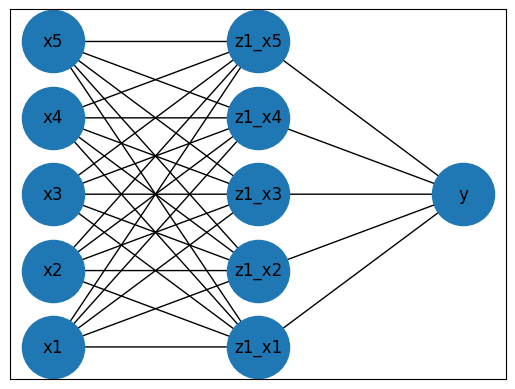

In [223]:
nn = NeuralNet()
nn.plot_network_graph()

In [154]:
loss = nn.fit(X_train, y_train, lr=0.001, epochs=1000)

100%|██████████| 1000/1000 [00:03<00:00, 257.58it/s]


In [155]:
y_test[0]

array([27.3])

In [156]:
nn.predict(X_test[0].reshape(1, -1))

array([[38.02289527]])

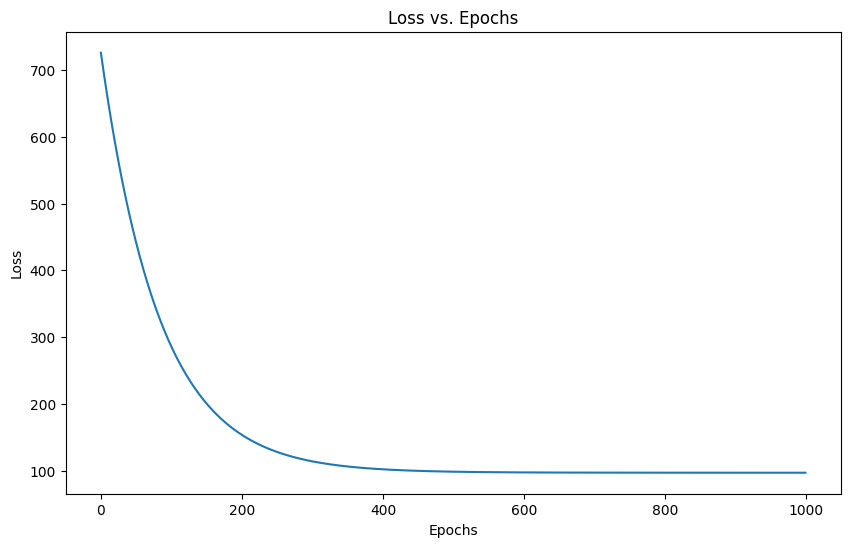

In [157]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(loss)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Loss vs. Epochs')
plt.show()

In [158]:
# Error cuadrático medio

nn.mse(y_test, X_test)

154.3024502218581

100%|██████████| 1000/1000 [00:03<00:00, 258.39it/s]


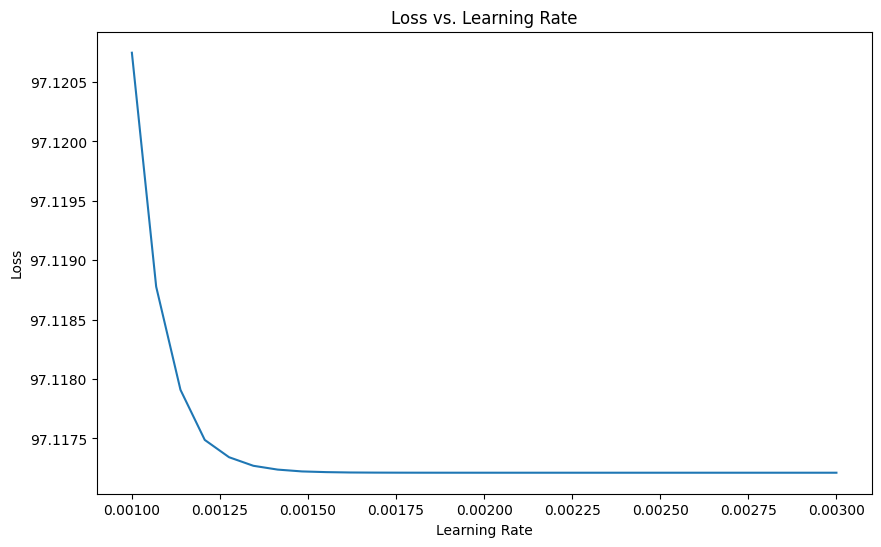

In [268]:
# Brute force para encontrar el mejor learning rate

lrs = np.linspace(0.001, 0.003, 30)
losses = []

for lr in lrs:
    nn = NeuralNet()
    nn.fit(X_train, y_train, lr=lr, epochs=1000)
    losses.append(nn.get_loss()[-1])

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(lrs, losses)
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Loss')
ax.set_title('Loss vs. Learning Rate')
plt.show()

In [272]:
list(zip(lrs, losses))

[(0.001, array([97.12074736])),
 (0.0010689655172413793, array([97.11877789])),
 (0.0011379310344827587, array([97.11790959])),
 (0.001206896551724138, array([97.11748762])),
 (0.0012758620689655173, array([97.11734209])),
 (0.0013448275862068967, array([97.11726998])),
 (0.001413793103448276, array([97.11723789])),
 (0.0014827586206896553, array([97.1172225])),
 (0.0015517241379310346, array([97.11721664])),
 (0.001620689655172414, array([97.11721355])),
 (0.0016896551724137933, array([97.11721248])),
 (0.0017586206896551726, array([97.11721199])),
 (0.0018275862068965517, array([97.11721175])),
 (0.001896551724137931, array([97.11721166])),
 (0.0019655172413793106, array([97.11721162])),
 (0.0020344827586206895, array([97.1172116])),
 (0.0021034482758620692, array([97.1172116])),
 (0.002172413793103448, array([97.11721159])),
 (0.002241379310344828, array([97.11721159])),
 (0.002310344827586207, array([97.11721159])),
 (0.0023793103448275866, array([97.11721159])),
 (0.00244827586206

In [278]:
m = min(losses)
#first occurrence of minimum
m_i = 30
for i, v in enumerate(losses):
    if v == m:
        m_i = i
        break
lrs[m_i], losses[m_i]

(0.003, array([97.11721159]))

In [285]:
nn = NeuralNet()
loss = nn.fit(X_train, y_train, lr=0.003, epochs=200)
loss[-1]

100%|██████████| 200/200 [00:00<00:00, 261.21it/s]


array([97.55767405])

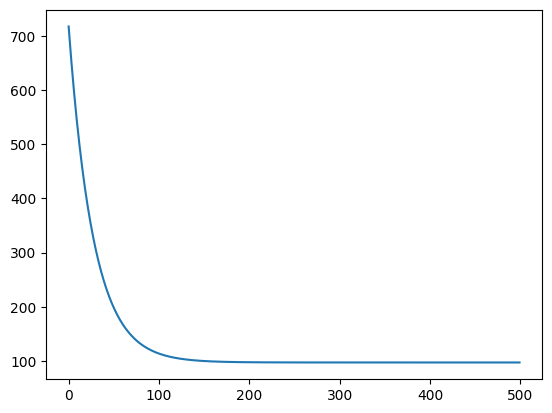

In [284]:
plt.plot(loss)